# Image clustering for Bristol Medical School PGRS

## Table of Contents
* [Aim of the course](#Aim)
* [Basics of Machine Learning](#The-basics-of-image-clustering)
* [Clustering multiple images](#Clustering-Multiple-Images)
* [Data augmentation](#Data-augmentation)
* [Geometric Transfromations](#Geometric-Transfromations)
* [Rotate the image](#Rotate-the-image)
* [Flip image horizontally](#Flip-the-image-horizontally)
* [Flip the image vertically](#Flip-the-image-vertically)
* [Blur the image](#Blur-the-image)
* [Visualise all images including the original image](#Visualise-all-images-including-the-original-image)
* [Resources](#Resources)

## Aim

To teach the concept of image clustering for analysis of medical images using a publicly available data set. The course will introduce ideas on data optimisation techniques with a focus on data augmentation, to improve machine learning in small imaging datasets. 

# The basics of image clustering

Machine learning can also be used on images. One method is clustering. Clustering is a form of unsupervised learning in which you seperate a large set of data into smaller groups based on distaces between them. In terms of images, clustering can be used to reduce the number of colours used in an image.

In this exercise we will demonstrate how clustering can be used to measure the size of different dermatological features.

Let's start by loading our first image from our directory and examining it's features:

Make sure to download our data from here: https://github.com/winfrednyoroka/Imagedata_augmentation_analysis/tree/e979e5cfc7e21f7e1b5ff4c2187ef5a5fdae2cda/Data/Raw

In [1]:
from PIL import Image
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

img_handle  = Image.open("../Data/Raw/mole.jpg") # Make sure to specify your own working directory
img = np.array(img_handle) #we need to first convert the image to a numpy array to ensure we can specify its dimensions 
print('Shape is', img.shape)
print("Size is", img.size)

Shape is (450, 600, 3)
Size is 810000


/var/folders/m1/0xsr32953nn05wqdqbd1p_1r0000gp/T/ipykernel_34413/2835849882.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img)


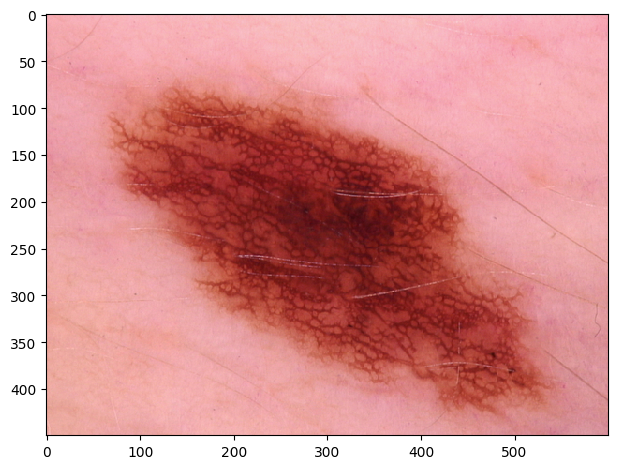

In [2]:
%matplotlib inline
io.imshow(img)
plt.show()

**NOTE FOR DAN/PAU** Is there a way we can load images straight from the github page to the notebook?

At the moment, the image is in 3 dimensions: 450 (height) x 600 (width) x 3 (colour). Color is 3 corresponding to RGB (red, green, blue). We want to flatten the image to two dimensional array (pixel x colour).

We then want to put this into a panda data frame for better plotting and processing. The data frame will have four columns: Red, Green, Blue and Colour - indicating the hex code of the pixel.

In [3]:
img = np.array(img, dtype=np.float64) / 255  # Scale values
w, h, d = original_shape = tuple(img.shape)  # Get the current shape
img_array = np.reshape(img, (w * h, d))  # Reshape to to 2D

#put into pandas data frame 
from pandas import DataFrame

pixels = DataFrame(img_array, columns=["Red", "Green", "Blue"])
#pixel = DataFrame(img_array, columns=["Red", "Green", "Blue"])
from matplotlib import colors

pixels["colour"] = [colors.to_hex(p) for p in img_array]
print(pixels)

             Red     Green      Blue   colour
0       0.949020  0.662745  0.698039  #f2a9b2
1       0.964706  0.678431  0.713725  #f6adb6
2       0.964706  0.678431  0.713725  #f6adb6
3       0.964706  0.686275  0.717647  #f6afb7
4       0.968627  0.690196  0.705882  #f7b0b4
...          ...       ...       ...      ...
269995  0.847059  0.572549  0.611765  #d8929c
269996  0.850980  0.576471  0.607843  #d9939b
269997  0.847059  0.572549  0.603922  #d8929a
269998  0.847059  0.564706  0.607843  #d8909b
269999  0.850980  0.568627  0.611765  #d9919c

[270000 rows x 4 columns]



**Exploring the data**

It is useful to plot the data before running the clustering.

Since we have a high amount of pixels (810000) running the algorithm may be slow. Therefore we can run it over a small subset of data.

In [4]:
pixels_sample = pixels.sample(frac=0.05) #look at 5% of the data

Since RGB pixels are a 3D dataset, we will plot three, 2D plots of the pairs red/green, red/blue and green/blue. 

To make our lives easier, we can define a function plot_colours() which will plot the three pairs of columns against each other.  To make the plots visually useful we will also colour each point in the plot with the colour of the pixel it came from using our fourth column, 'Colour'.

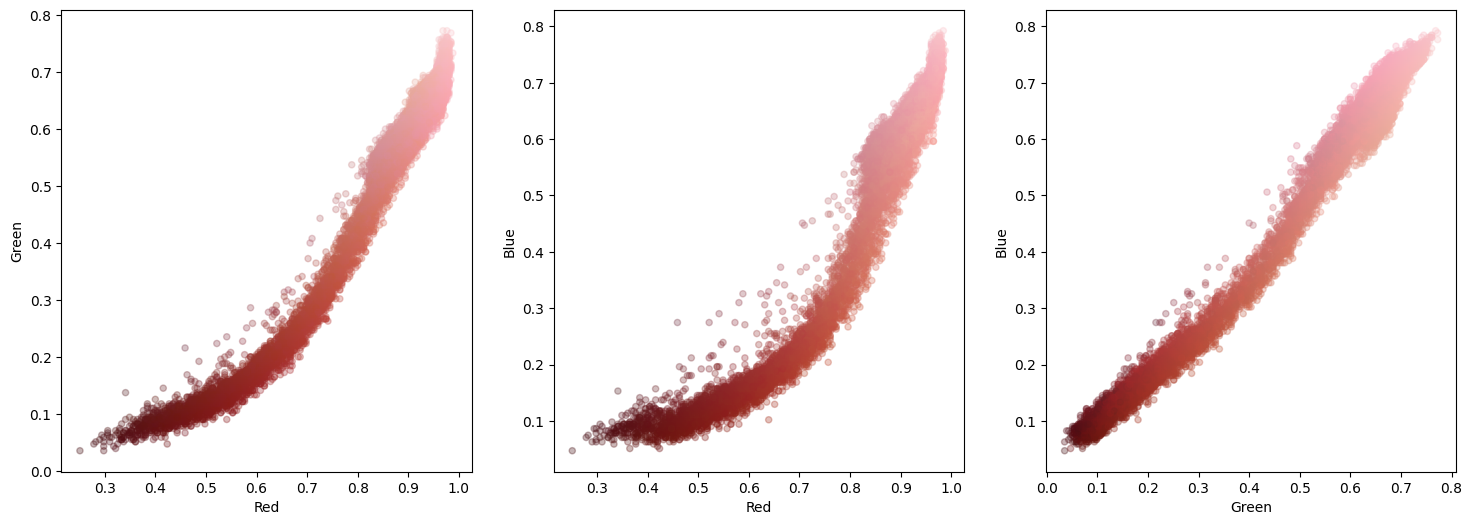

In [5]:
import matplotlib.pyplot as plt


def plot_colours(df, c1, c2, c3):
    """
    Given a DataFrame and three column names,
    plot the pairs against each other
    """
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    df.plot.scatter(c1, c2, c=df["colour"], alpha=0.3, ax=ax[0])
    df.plot.scatter(c1, c3, c=df["colour"], alpha=0.3, ax=ax[1])
    df.plot.scatter(c2, c3, c=df["colour"], alpha=0.3, ax=ax[2])


plot_colours(pixels_sample, "Red", "Green", "Blue")
plt.show()

1st plot: Red  vs green, represents a non-linear relationship between red and green,red increases and green increases at a different rate.

2nd plot: Red vs blue, a curved upward trend  where red values have higher blue values. However, the spread is more eminent at lower levels of red intensity.

3rd plot: Green vs blue, a curved relationship with strong positive correlation with limited spread. Meaning as green increases blue increases.


Overall this shows we have a strong correlation between colour channels and the colours are highly dependent as shown by high correlation.

Sometimes viewing the data in 3D can help since planar projections can lose some nuances of the data. Display 3D plots using the **mplot3d package**.

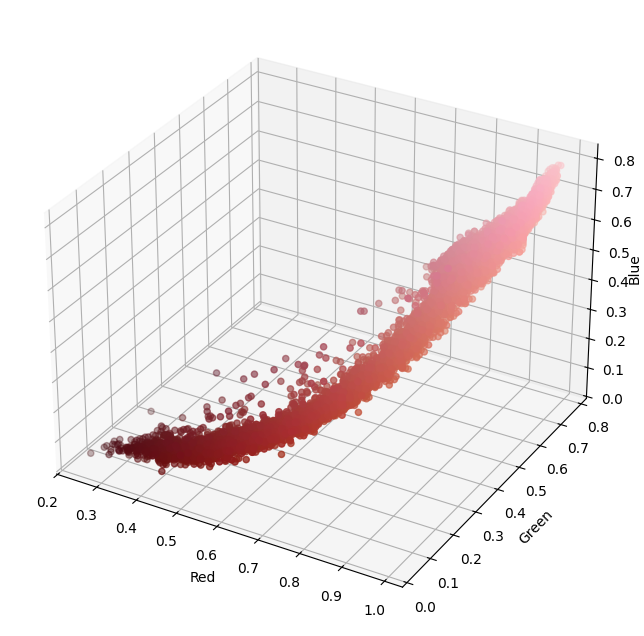

In [6]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue",labelpad=-2,rotation=90) # Rotate the z-axis label to fit
ax.scatter(pixels_sample["Red"], pixels_sample["Green"], pixels_sample["Blue"], c=pixels_sample["colour"])
plt.show()

**NOTE FOR DAN/PAU** We've taken this descriptive task from the original image clustering training but we're unsure what to provide as an interpretation for these graphs?

**Assigning points to clusters**

Now we can begin the clustering. We will be using a method called **k-means clustering**. It works by initialising K cluster centres, assigning each data point (pixel in this case) to the nearest centre. It then works through the data set, assigning each pixel and updating the clusters if needed. The process continues until no more updates to the clusters are required. 

We can run the clustering and display our cluster centres using the code below:

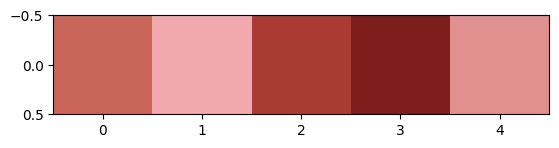

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init="auto").fit(pixels_sample[["Red", "Green", "Blue"]])
plt.imshow([kmeans.cluster_centers_])
plt.show()

Now we have our clusters which we can use as our representative clusters for the image. We can now go through the original image and assign each pixel to a cluster that it is nearest to.

In [8]:
labels = kmeans.predict(pixels[["Red", "Green", "Blue"]])
labels

array([1, 1, 1, ..., 4, 4, 4], shape=(270000,), dtype=int32)

To quantify these predictions we can plot a bar graph to show how many pixels are in each cluster 

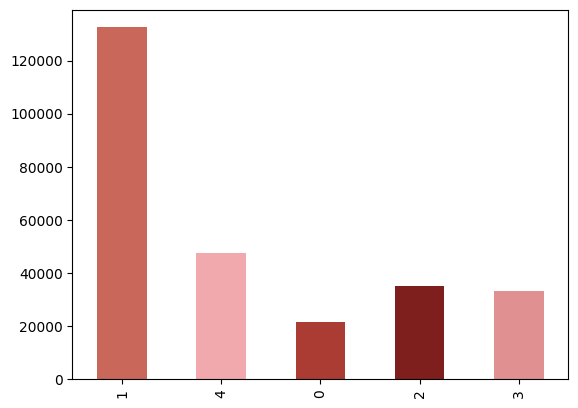

In [9]:
from pandas import DataFrame, Series
%matplotlib inline

Series(labels).value_counts(sort=False).plot.bar(color=kmeans.cluster_centers_)
plt.show()

To assess how well the algorithm has clustered the images, we can plot the clustered pixels next to the original image to observe the differences. 

First we need to convert our clustered pixels back to a 3D array (width x height x colour):

In [10]:
reduced = np.array([kmeans.cluster_centers_[p] for p in labels]).reshape(original_shape)


We can then plot the images next to each other.

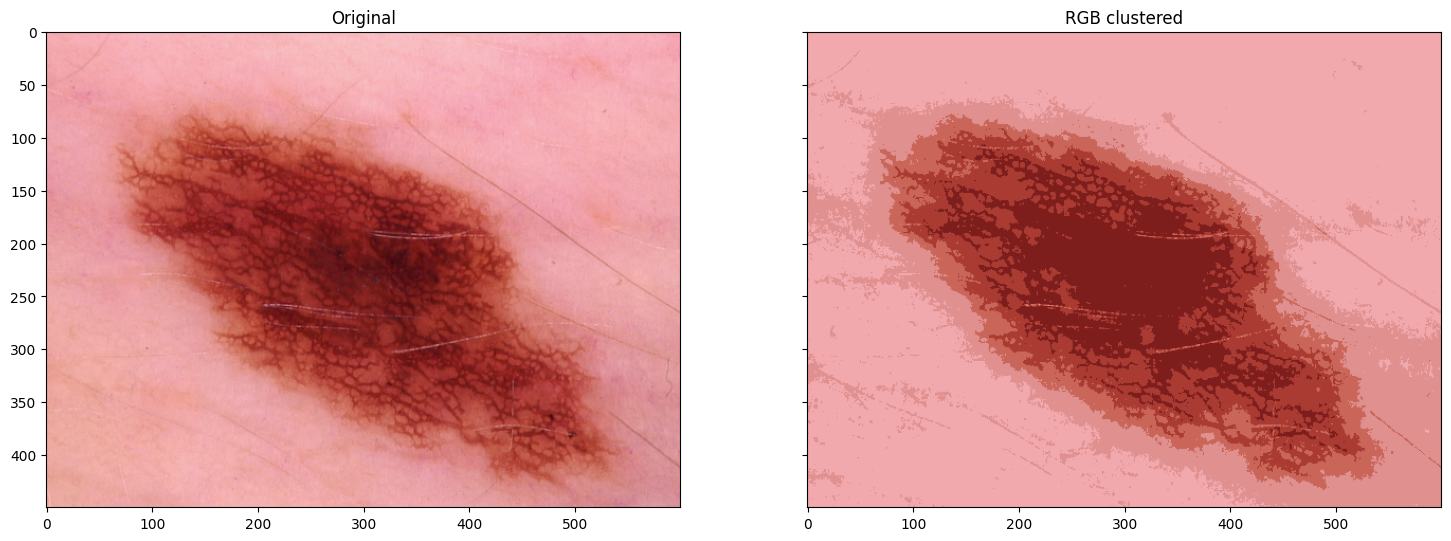

In [11]:
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 9))
axarr[0].imshow(img)
axarr[0].set_title("Original")
axarr[1].imshow(reduced)
axarr[1].set_title("RGB clustered")
plt.show()

Here it has done a pretty good job at identfying the main darker spots, but finer features such as hair are undefined. We could try to improve this by increasing the number of clusters.

1. What number of clusters do you think are sufficient to define all features?
2. Set the number of clusters to 2. Does this sufficiently distinguish between mole and not mole?

**Exercise:** Take a look at another image clustering exercise here. It explains different methods for colouring space. Have a go at using and comparing the different methods?

https://bristol-training.github.io/applied-data-analysis-in-python/pages/appendix_clustering_images.html 

# Clustering Multiple Images

In the next step we are going to use this clustering technique to measure the surface area of dermatological features in a set of 3 images. This could be used as a technique to measure features in a large data set that are hard or tedious to quantify.

First we need to load and inspect the images in the same way we did in the previous exercise

Image 1 shape is (450, 600, 3)
Image 1 size is 810000


/var/folders/m1/0xsr32953nn05wqdqbd1p_1r0000gp/T/ipykernel_34413/1600207539.py:13: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img1)


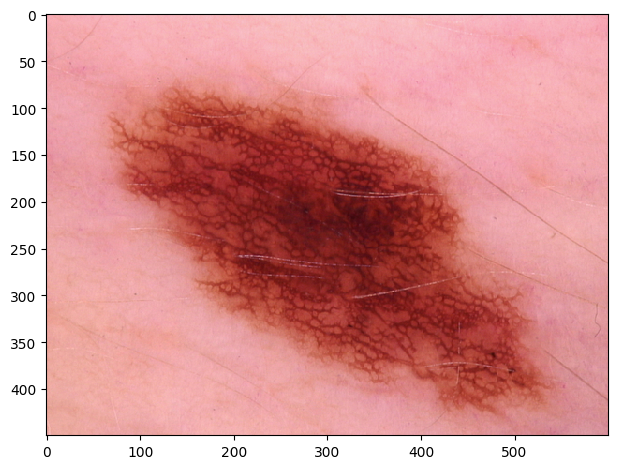

Image 2 shape is (450, 600, 3)
Image 2 size is 810000


/var/folders/m1/0xsr32953nn05wqdqbd1p_1r0000gp/T/ipykernel_34413/1600207539.py:23: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img2)


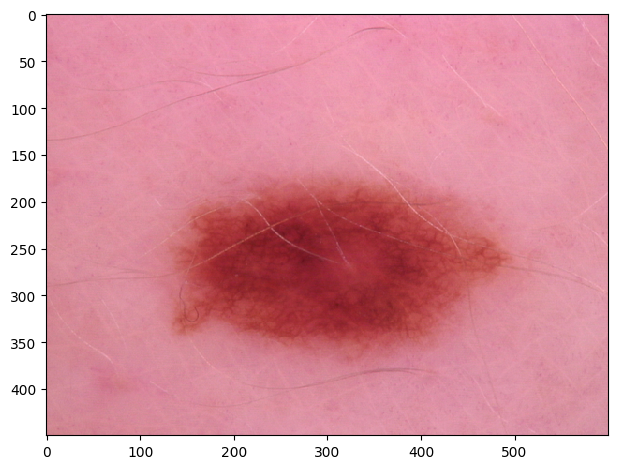

Image 3 shape is (450, 600, 3)
Image 3 size is 810000


/var/folders/m1/0xsr32953nn05wqdqbd1p_1r0000gp/T/ipykernel_34413/1600207539.py:33: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img3)


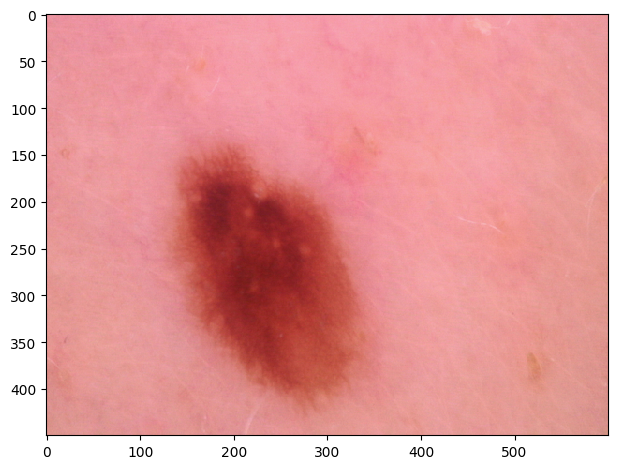

In [12]:
from PIL import Image
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

#image 1
img1  = Image.open("../Data/Raw/mole.jpg") #make sure to specify your own working directory
img1 = np.array(img1)
print('Image 1 shape is', img1.shape)
print("Image 1 size is", img1.size)

%matplotlib inline
io.imshow(img1)
plt.show()

#image 2
img2  = Image.open("../Data/Raw/mole2.jpg") #make sure to specify your own working directory
img2 = np.array(img2)
print('Image 2 shape is', img2.shape)
print("Image 2 size is", img2.size)

%matplotlib inline
io.imshow(img2)
plt.show()

#image 3
img3  = Image.open("../Data/Raw/mole3.jpg") #make sure to specify your own working directory
img3 = np.array(img3)
print('Image 3 shape is', img3.shape)
print("Image 3 size is", img3.size)

%matplotlib inline
io.imshow(img3)
plt.show()

We also need to flatten them and convert into a pandas data frames

In [13]:
from pandas import DataFrame
from matplotlib import colors

#image 1
img1 = np.array(img1, dtype=np.float64) / 255  # Scale values
w, h, d = original_shape = tuple(img1.shape)  # Get the current shape
img1_array = np.reshape(img1, (w * h, d))  # Reshape to to 2D

pixels1 = DataFrame(img1_array, columns=["Red", "Green", "Blue"]) #convert to pandas
pixels1["colour"] = [colors.to_hex(p) for p in img1_array] #add colours column 
print(pixels1)

#image 2
img2 = np.array(img2, dtype=np.float64) / 255  # Scale values
w, h, d = original_shape = tuple(img2.shape)  # Get the current shape
img2_array = np.reshape(img2, (w * h, d))  # Reshape to to 2D

pixels2 = DataFrame(img2_array, columns=["Red", "Green", "Blue"]) #convert to pandas
pixels2["colour"] = [colors.to_hex(p) for p in img2_array] #add colours column 
print(pixels2)

#image 3
img3 = np.array(img3, dtype=np.float64) / 255  # Scale values
w, h, d = original_shape = tuple(img3.shape)  # Get the current shape
img3_array = np.reshape(img3, (w * h, d))  # Reshape to to 2D

pixels3 = DataFrame(img3_array, columns=["Red", "Green", "Blue"]) #convert to pandas
pixels3["colour"] = [colors.to_hex(p) for p in img3_array] #add colours column 
print(pixels3)

             Red     Green      Blue   colour
0       0.949020  0.662745  0.698039  #f2a9b2
1       0.964706  0.678431  0.713725  #f6adb6
2       0.964706  0.678431  0.713725  #f6adb6
3       0.964706  0.686275  0.717647  #f6afb7
4       0.968627  0.690196  0.705882  #f7b0b4
...          ...       ...       ...      ...
269995  0.847059  0.572549  0.611765  #d8929c
269996  0.850980  0.576471  0.607843  #d9939b
269997  0.847059  0.572549  0.603922  #d8929a
269998  0.847059  0.564706  0.607843  #d8909b
269999  0.850980  0.568627  0.611765  #d9919c

[270000 rows x 4 columns]
             Red     Green      Blue   colour
0       0.890196  0.560784  0.650980  #e38fa6
1       0.894118  0.564706  0.654902  #e490a7
2       0.886275  0.556863  0.647059  #e28ea5
3       0.874510  0.564706  0.639216  #df90a3
4       0.878431  0.568627  0.654902  #e091a7
...          ...       ...       ...      ...
269995  0.843137  0.560784  0.647059  #d78fa5
269996  0.823529  0.556863  0.639216  #d28ea3
269997 

**Exercise**: At the moment we are loading and editing each image seperately - this can be time consuming with large data sets. How can we make this process faster? 

*Answer: For loop below*

In [14]:
### Solution
import os
# Set a directory variable name containing images
image_dir = "../Data/Raw/"

# List all image files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith((".jpg", ".png", ".jpeg"))]
print(f'These are the image file names in the current working directory: {image_files}') # View file names

# Loop through images
for file in image_files:
    img_path = os.path.join(image_dir, file)
    img = io.imread(img_path)  # Load the image
    
    # Normalize pixel values (scale between 0 and 1)
    img = np.array(img, dtype=np.float64) / 255  

    # Get the shape of the image
    w, h, d = img.shape  

    # Reshape into a 2D array of pixels
    img_array = np.reshape(img, (w * h, d))  

    # Convert to a Pandas DataFrame
    pixels = DataFrame(img_array, columns=["Red", "Green", "Blue"])  
   
    pixels["colour"] = [colors.to_hex(p) for p in img_array]  # Convert RGB to HEX colors
    print(pixels.head())

These are the image file names in the current working directory: ['mole2.jpg', 'mole3.jpg', 'mole.jpg']
        Red     Green      Blue   colour
0  0.890196  0.560784  0.650980  #e38fa6
1  0.894118  0.564706  0.654902  #e490a7
2  0.886275  0.556863  0.647059  #e28ea5
3  0.874510  0.564706  0.639216  #df90a3
4  0.878431  0.568627  0.654902  #e091a7
        Red     Green      Blue   colour
0  0.905882  0.576471  0.627451  #e793a0
1  0.913725  0.592157  0.639216  #e997a3
2  0.913725  0.592157  0.639216  #e997a3
3  0.925490  0.596078  0.647059  #ec98a5
4  0.925490  0.596078  0.647059  #ec98a5
        Red     Green      Blue   colour
0  0.949020  0.662745  0.698039  #f2a9b2
1  0.964706  0.678431  0.713725  #f6adb6
2  0.964706  0.678431  0.713725  #f6adb6
3  0.964706  0.686275  0.717647  #f6afb7
4  0.968627  0.690196  0.705882  #f7b0b4


To run the clustering on a set of images we need to stack the data frames into one. We will add a new column to indicate which image the data came from. 

In [15]:
# First we need to add a new column to our data sets to indicate which image they came from 
import pandas as pd

pixels1['image'] = '1'
pixels2['image'] = '2'
pixels3['image'] = '3'

pixels = pd.concat([pixels1, pixels2, pixels3], ignore_index = True, axis = 0) #axis 0 indicates stacking verticallu

print(pixels)


             Red     Green      Blue   colour image
0       0.949020  0.662745  0.698039  #f2a9b2     1
1       0.964706  0.678431  0.713725  #f6adb6     1
2       0.964706  0.678431  0.713725  #f6adb6     1
3       0.964706  0.686275  0.717647  #f6afb7     1
4       0.968627  0.690196  0.705882  #f7b0b4     1
...          ...       ...       ...      ...   ...
809995  0.827451  0.560784  0.525490  #d38f86     3
809996  0.831373  0.564706  0.521569  #d49085     3
809997  0.839216  0.580392  0.525490  #d69486     3
809998  0.839216  0.580392  0.525490  #d69486     3
809999  0.823529  0.576471  0.509804  #d29382     3

[810000 rows x 5 columns]


**Exercise** Explore the data in the same way as the previous exercise. Do you notice anything from the correlations?

We can now run K-means clustering in the same way as before. First by sampling a subset of pixels and assign our cluster centres. In order to compare the size of the dermatological features across the images, we want to measure the pixels that are and aren't dark space. We could try to use 2 clusters for this.

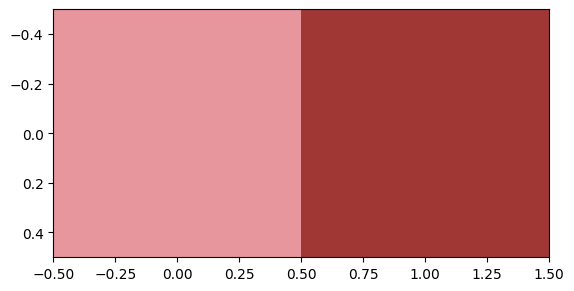

In [16]:
pixels_sample = pixels.sample(frac=0.05) #look at 5% of the data

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init="auto").fit(pixels_sample[["Red", "Green", "Blue"]])
plt.imshow([kmeans.cluster_centers_])
plt.show()


In the same way as before see how it looks compared to the original image. Does two clusters sufficiently define the dark areas. **NOTE** *Could make this an exercise?*   **@Catherine have a look at this cell**

We can now run our clustering with our whole data set.

In [17]:
labels = kmeans.predict(pixels[["Red", "Green", "Blue"]])
labels

array([0, 0, 0, ..., 0, 0, 0], shape=(810000,), dtype=int32)

Now we have used the clustering algorithm to cluster pixels into dark and light areas, we can manipulate our data frame to compare the size of the features in the images. 

First we want to add the clustering array to the pandas data frame 

In [18]:
# Add the clustering array as a new column 

pixels['cluster'] = labels.tolist()
print(pixels)

             Red     Green      Blue   colour image  cluster
0       0.949020  0.662745  0.698039  #f2a9b2     1        0
1       0.964706  0.678431  0.713725  #f6adb6     1        0
2       0.964706  0.678431  0.713725  #f6adb6     1        0
3       0.964706  0.686275  0.717647  #f6afb7     1        0
4       0.968627  0.690196  0.705882  #f7b0b4     1        0
...          ...       ...       ...      ...   ...      ...
809995  0.827451  0.560784  0.525490  #d38f86     3        0
809996  0.831373  0.564706  0.521569  #d49085     3        0
809997  0.839216  0.580392  0.525490  #d69486     3        0
809998  0.839216  0.580392  0.525490  #d69486     3        0
809999  0.823529  0.576471  0.509804  #d29382     3        0

[810000 rows x 6 columns]


We can then plot the amount of dark space for each image  

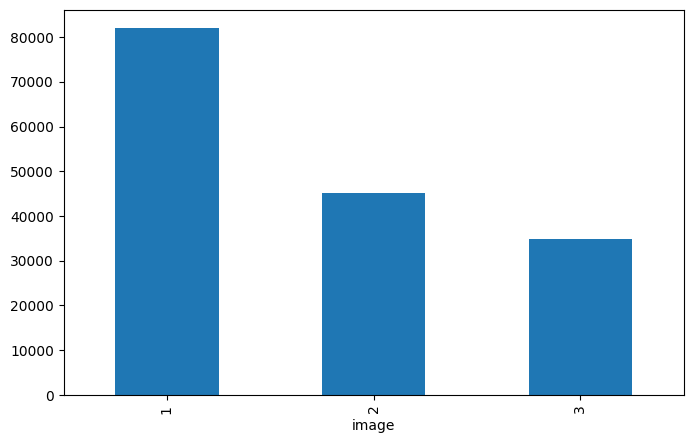

In [19]:
# Filter only rows where cluster == 0
pixels_fil = pixels[pixels["cluster"] == 1]

# Count occurrences of cluster 0 per image
dark_counts= pixels_fil["image"].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
dark_counts.plot(kind="bar")
plt.show()

In a real data set we would have lots of different images. Using clustering this way would save time in measuring images. 

Can you think of other applications? Cell types on slides - how many clusters would you want then? 

We are moving on to a different aspect of clustering images **addressing the problem of limited image data**.    

Mostly we have access to limited medical image data. This amount of data is insufficient to train a machine learning algorithm that is good enough to decipher between diseased and not diseased.
Therefore, we will explore alternative strategies of creating more data from existing dataset to boost model performance.

# Data augmentation
- Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.

- Aimed at creating new data points, manipulating existing data to increase the size and diversity of a dataset.

**Why is it important?**

1. Enhanced Model performance.     
   Data augmentation techniques help enrich datasets by creating many variations of existing data. This provides a larger dataset for training and enables a model to encounter more diverse features. The augmented data helps the model better generalize to unseen data and improve its overall performance in real-world environments. 
2. To prevent models from overfitting.       
   Overfitting is the undesirable ML behavior where a model can accurately provide predictions for training data but it struggles with new data. If a model trains only with a narrow dataset, it can become overfit and can give predictions related to only that specific data type.
3. The initial training set is too small. 
4. To improve the model accuracy.       
   If you need to train a deep learning model on sensitive data, you can use augmentation techniques on the existing data to create synthetic data.
6. To reduce the operational cost of labeling and cleaning the raw dataset.      
   Data augmentation techniques increase the effectiveness of smaller datasets, vastly reducing the dependency on large datasets in training environments.


**Example use case**
1. Health care - Image analysis.     
   Useful technology in medical imaging because it helps improve diagnostic models that detect, recognize, and diagnose diseases based on images. The creation of an augmented image provides more training data for models, especially for rare diseases that lack source data variations. The production and use of synthetic patient data advances medical research while respecting all data privacy considerations.

**How do you achieve Image data augmentation?**

- In image processing, applying geomteric transformations like rotations, flips, or color adjustments to existing images can help models generalize better.

- Other transformations are:

  i) *Color space transformations:* randomly change RGB color channels, contrast, and brightness.

  
  ii) *Kernel filters:* randomly change the sharpness or blurring of the image.

  
  iii) *Random erasing:* delete some part of the initial image.

  
  iv) *Mixing images:* blending and mixing multiple images. 


## Geometric Transformations

In this session we will focus on geometric transformations only including: rotating images, flipping and blurring the images.

![Geometrictransformations](../Figures/Image_Transformations.png)


In [20]:
# Load the necessary libraries
import skimage
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data   ## Inbuilt dataset within scikit-image
from skimage import io, transform, filters, exposure
matplotlib.rcParams['font.size'] = 18

In [22]:
# We are working with one file at a time for now.
# Read in the image data
image = io.imread("../Data/Raw/mole.jpg") 

## Rotate the image

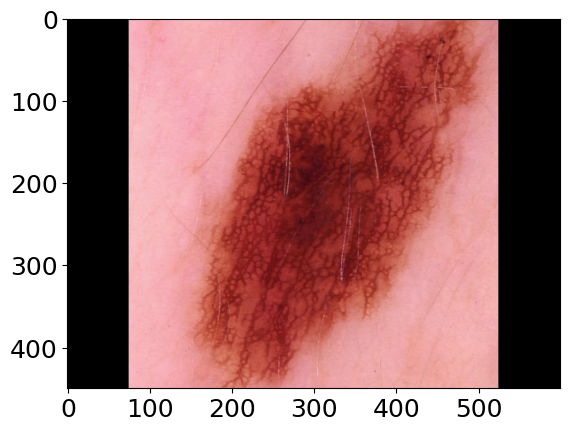

In [23]:
# Rotate the image
rotated = transform.rotate(image, 90)  # Rotate 90 degrees
plt.imshow(rotated)

## Flip the image horizontally

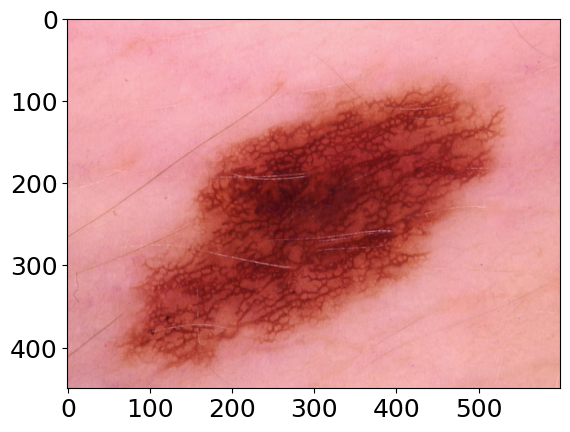

In [24]:
# Flip the image horizontally
flipped_h = image[:, ::-1]
plt.imshow(flipped_h) 

## Flip the image vertically

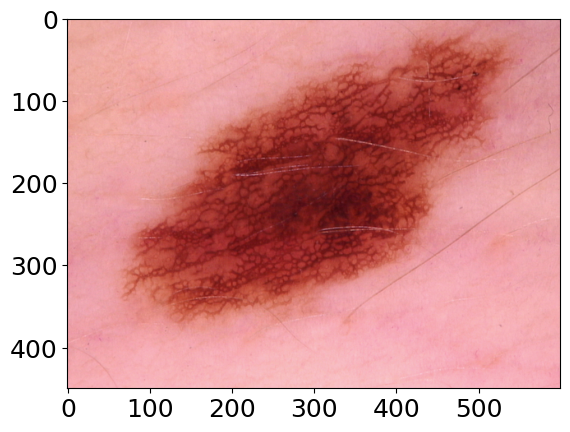

In [25]:
flipped_v = image[::-1, :]  
plt.imshow(flipped_v)

## Blur the image

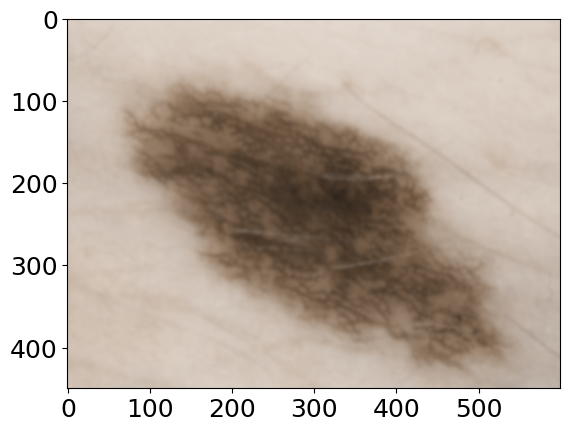

In [26]:
# Blur the image
blurred = filters.gaussian(image, sigma=2)
plt.imshow(blurred)

# Visualise all images including the original image

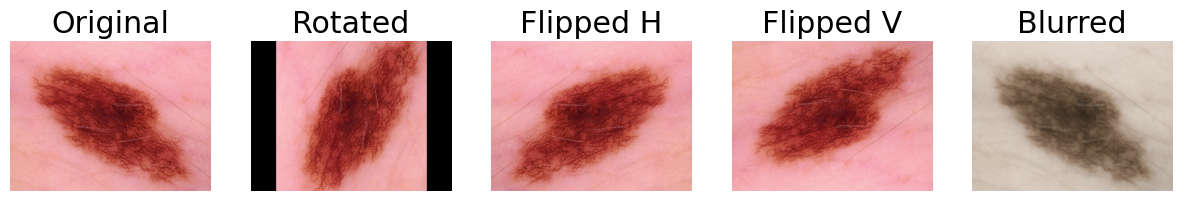

In [27]:
# Visualise the original and modified forms of the image all together
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
titles = ["Original", "Rotated", "Flipped H", "Flipped V", "Blurred"]
images = [image, rotated, flipped_h, flipped_v, blurred]

for ax, title, image in zip(axes, titles, images):
    ax.imshow(image, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()

We have been reading in one image at a time and applying the transformations on each image at a time. Can you work out how to process mutiple images all at once?

Consider using the three image files provided in `../Data/Raw/`


['mole2.jpg', 'mole3.jpg', 'mole.jpg']


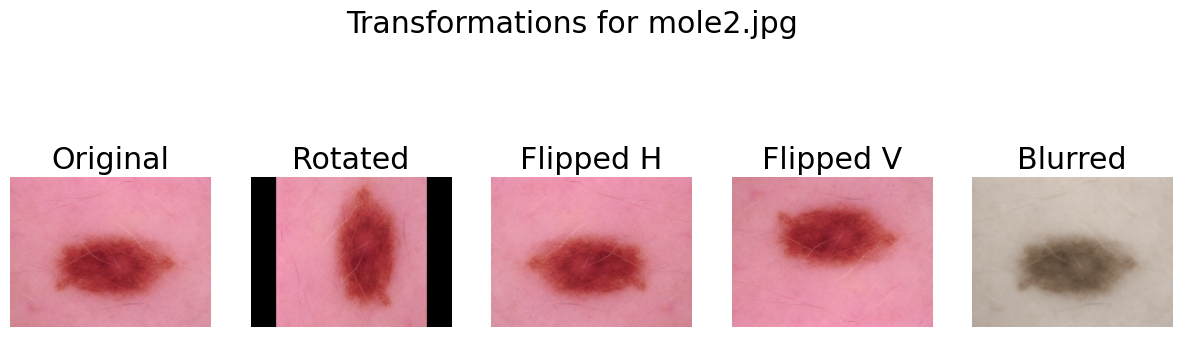

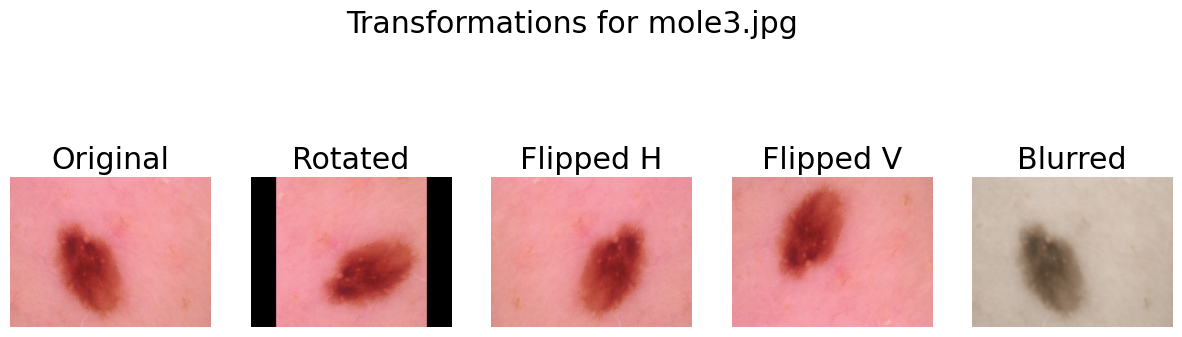

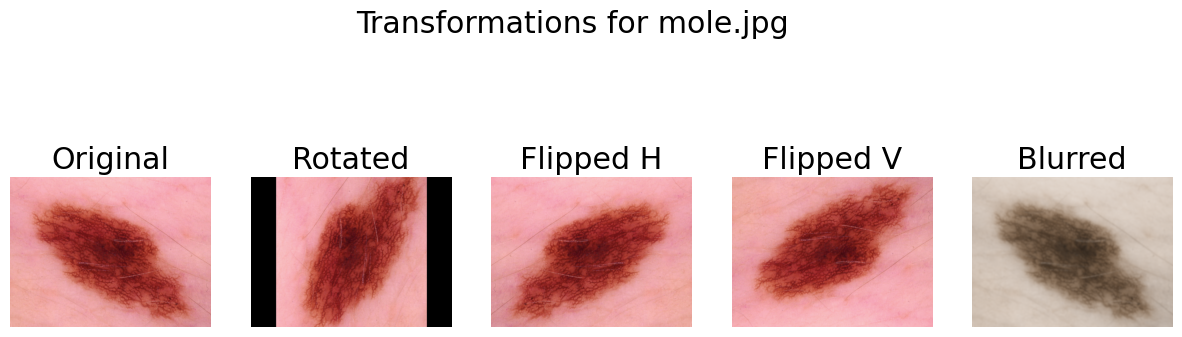

In [28]:
#### Solution
import os
import matplotlib.pyplot as plt
from skimage import io, transform, filters

# Set a directory variable name containing images
image_dir = "../Data/Raw/"

# List all image files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith((".jpg", ".png", ".jpeg"))]
print(image_files) 

# Loop through images
for file in image_files:
    img_path = os.path.join(image_dir, file)
    img = io.imread(img_path)  # Load the image

    # Apply transformations
    rotated = transform.rotate(img, 90)
    flipped_h = img[:, ::-1]  # Flip horizontally
    flipped_v = img[::-1, :]  # Flip vertically
    blurred = filters.gaussian(img, sigma=2)

    # Visualize transformations
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    titles = ["Original", "Rotated", "Flipped H", "Flipped V", "Blurred"]
    images = [img, rotated, flipped_h, flipped_v, blurred]

    for ax, title, image in zip(axes, titles, images):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle(f"Transformations for {file}")
    plt.show()

Play around with the rotation angles and observe variations to the image dataset.

Experiment with varying amounts of sigma for blurring, what dod you observe happening to the images?

**Hint**   
`
blurred1 = filters.gaussian(img, sigma=1)  
`     
`
blurred5 = filters.gaussian(img, sigma=5)  
`       
`
blurred10 = filters.gaussian(img, sigma=10)    
`   
How does each of the blurring differ from one another?



### At your own time explore inbuilt scikit-image medical datasets

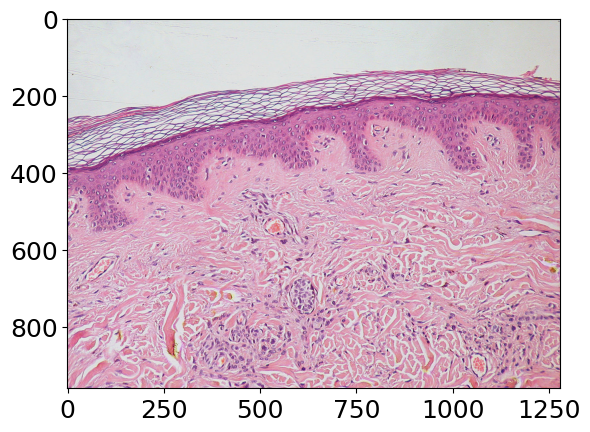

In [29]:
# Load inbuilt skin dataset from scikit-image
image = data.skin()
image # Displays an array representing the image
plt.imshow(image) # Visualise the original image

# Resources

1. [Data augmentation using AWS](https://aws.amazon.com/what-is/data-augmentation/#:~:text=Data%20augmentation%20is%20the%20process,machine%20learning%20(ML)%20models.)

2. [Scikit-image](https://scikit-image.org/docs/stable/user_guide/install.html)